In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import layers, models

C:\Users\51man\AppData\Local\Temp\ipykernel_14864\3706376448.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from IPython.display import Audio
import librosa.display

file_path = 'data/fold1/101415-3-0-2.wav'

audio, sr = librosa.load(file_path)

Audio(data=audio, rate=sr)

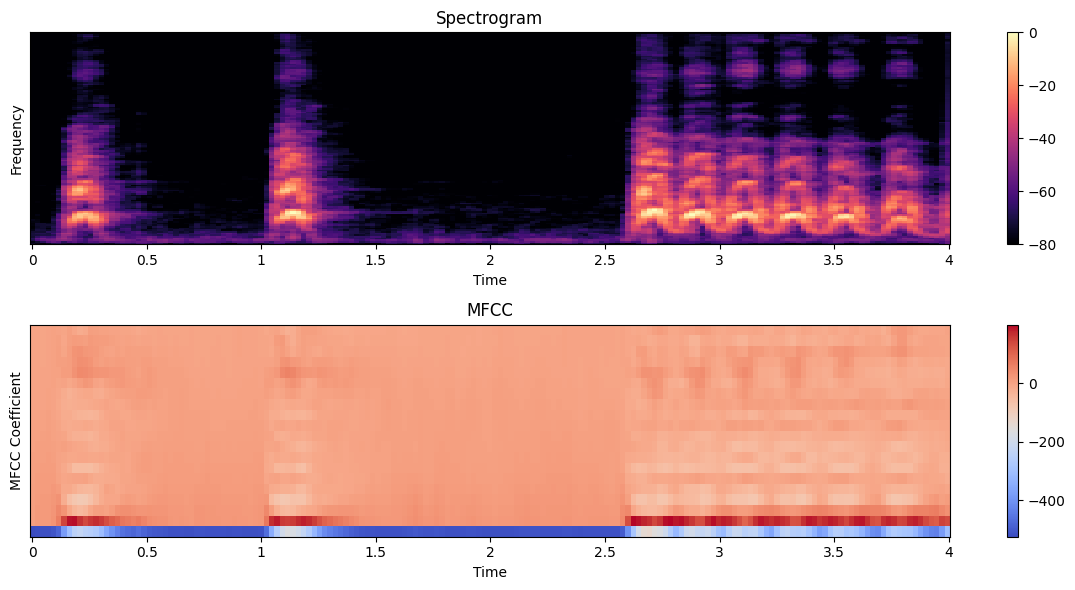

In [10]:
import matplotlib.pyplot as plt

file_path = 'data/fold1/101415-3-0-2.wav'

audio, sr = librosa.load(file_path)

spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),  x_axis='time')
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficient')

plt.tight_layout()
plt.show()


In [7]:
metadata = pd.read_csv('UrbanSound8K.csv')

In [8]:
def extract_features_mfcc(file_path, duration=4, n_mfcc=20):
    audio, sr = librosa.load(file_path, duration=duration, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def extract_features_spectrogram(file_path, duration=4):
    audio, sr = librosa.load(file_path, duration=duration, res_type='kaiser_fast')
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    return spectrogram

In [9]:
def preprocess_data(data, feature_extractor):
    features = []
    labels = []
    max_shape = (0, 0)
    
    for index, row in data.iterrows():
        file_path = os.path.join('urbansound', 'fold' + str(row['fold']), row['slice_file_name'])
        if(os.path.exists(file_path)):
            if feature_extractor == 'mfcc':
                feature = extract_features_mfcc(file_path)
            elif feature_extractor == 'spectrogram':
                feature = extract_features_spectrogram(file_path)
            
            max_shape = (max(max_shape[0], feature.shape[0]), max(max_shape[1], feature.shape[1]))
            
            features.append(feature)
            labels.append(row['classID'])
    
    padded_features = []
    for arr in features:
        pad_width = ((0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1]))
        padded_arr = np.pad(arr, pad_width, mode='constant')
        padded_features.append(padded_arr)
    
    return padded_features, labels

In [10]:
feature_extractor = 'mfcc'
features, labels = preprocess_data(metadata, feature_extractor)

In [10]:
X = np.array(features)
y = np.array(labels)
print(X)
print(y)

[[[-7.09551392e+02 -6.95568298e+02 -6.42164612e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.31995754e+01  3.89292297e+01  9.23563232e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.30549622e+01  2.85257645e+01  3.49253769e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 1.28071918e+01  1.67370586e+01  1.55366154e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.19384289e+01  1.73178177e+01  1.91239567e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.10930414e+01  1.54493389e+01  1.10178509e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-6.29074341e+02 -6.25328247e+02 -6.23461121e+02 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.59614391e+01  3.06188431e+01  3.28600311e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.71774101e+01  2.00737972e+01  2.12429543e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [-2.50826979e+00 -4.6

In [11]:
X = (X - np.mean(X)) / np.std(X)

label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)

(228, 20, 173)
(58, 20, 173)


In [13]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
print(X_train.shape)
print(X_val.shape)

(228, 20, 173, 1)
(58, 20, 173, 1)


In [14]:
input_shape = X_train[0].shape
num_classes = y_train.shape[1]
print(input_shape)
print(num_classes)

(20, 173, 1)
9


In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 173, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 86, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 43, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 43, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 21, 128)        0

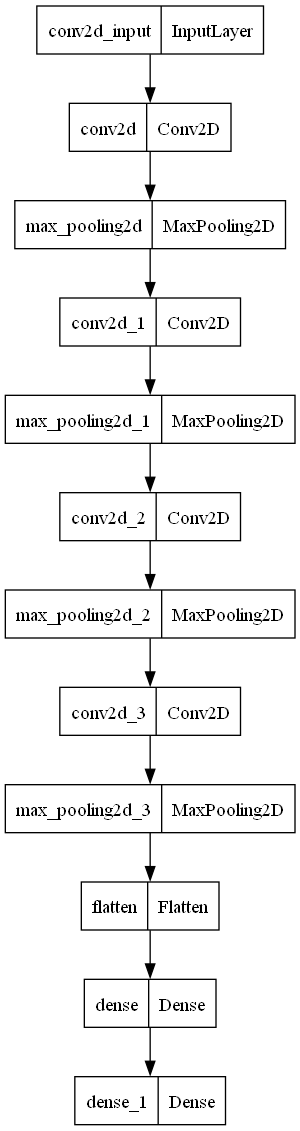

In [17]:
import pydot
from keras.utils import plot_model

plot_model(model, to_file='cnn_audio_librosa.png')


In [18]:
from keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir='./log',histogram_freq=1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val),callbacks=[tensorboard_callback])


Epoch 1/10


8/8 [==============================] - 1s 72ms/step - loss: 2.0607 - accuracy: 0.2018 - val_loss: 1.8674 - val_accuracy: 0.3276
Epoch 2/10
8/8 [==============================] - 0s 40ms/step - loss: 1.7016 - accuracy: 0.3596 - val_loss: 1.5015 - val_accuracy: 0.5172
Epoch 3/10
8/8 [==============================] - 0s 39ms/step - loss: 1.5641 - accuracy: 0.4079 - val_loss: 1.4926 - val_accuracy: 0.5345
Epoch 4/10
8/8 [==============================] - 0s 39ms/step - loss: 1.2695 - accuracy: 0.4825 - val_loss: 1.4461 - val_accuracy: 0.5000
Epoch 5/10
8/8 [==============================] - 0s 38ms/step - loss: 1.2211 - accuracy: 0.5439 - val_loss: 1.3816 - val_accuracy: 0.5517
Epoch 6/10
8/8 [==============================] - 0s 40ms/step - loss: 1.0685 - accuracy: 0.5570 - val_loss: 1.1578 - val_accuracy: 0.5862
Epoch 7/10
8/8 [==============================] - 0s 38ms/step - loss: 0.8345 - accuracy: 0.7018 - val_loss: 1.0334 - val_accuracy: 0.6724
Epoch 8/10
8/8 [=========

In [19]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Accuracy:", accuracy)

2/2 [==============================] - 0s 11ms/step - loss: 0.9772 - accuracy: 0.6897
Accuracy: 0.6896551847457886


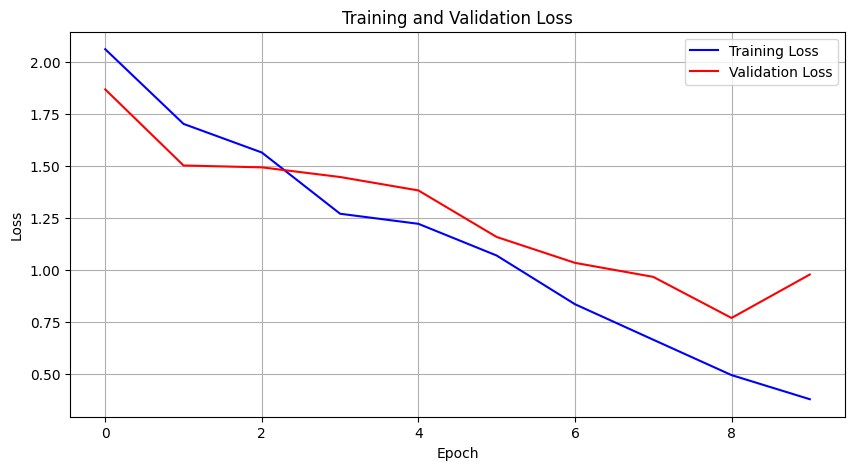

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
test_file_path = ''

def extract_features_mfcc_test(file_path, duration=4, n_mfcc=20):
    audio, sr = librosa.load(file_path, duration=duration, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def preprocess_features_test(features, max_shape):
    pad_width = ((0, max_shape[0] - features.shape[0]), (0, max_shape[1] - features.shape[1]))
    padded_features = np.pad(features, pad_width, mode='constant')
    return padded_features

max_shape = (20, 173)
class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

test_features = extract_features_mfcc_test(test_file_path)

padded_test_features = preprocess_features_test(test_features, max_shape)

padded_test_features = np.expand_dims(padded_test_features, axis=0)

class_probabilities_test = model.predict(padded_test_features)

predicted_class_index_test = np.argmax(class_probabilities_test)

predicted_class_name_test = class_names[predicted_class_index_test]

print("Predicted Class for Test Audio File:", predicted_class_name_test)


1/1 [==============================] - 0s 100ms/step
Predicted Class for Test Audio File: car_horn
